In [ ]:
import torch
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH = "/content/drive/MyDrive/Màster Ciència de Dades 2021-2025/master/2024-2025_2n_Sem/🏈 Treball de Final de Màster/notebooks/model/"

In [4]:
inici_carrega = time.time()
print("Càrrega de dades test...")
dataset_test = torch.load(os.path.join(PATH, 'nested_plays_test.pt'), weights_only=False)
final_carrega = time.time()
print(f"Càrrega de dades: {final_carrega - inici_carrega:.2f} segons")

Càrrega de dades test...
Càrrega de dades: 14.00 segons


In [5]:
inici_carrega = time.time()
print("Càrrega de dades train...")
dataset_train = torch.load(os.path.join(PATH, 'nested_plays_train.pt'), weights_only=False)
final_carrega = time.time()
print(f"Càrrega de dades: {final_carrega - inici_carrega:.2f} segons")

Càrrega de dades train...
Càrrega de dades: 47.82 segons


## Model de Deep Sets

In [6]:
class PlayDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        play = self.data[index]
        players = play["players"]
        label = torch.tensor(play["label"], dtype=torch.long)

        player_features = [player["features"] for player in players]
        tracking_sequence = [player["movements"] for player in players]

        return {
            "player_features": player_features,
            "tracking_sequence": tracking_sequence,
        }, label

In [7]:
def collate_fn(batch):
    plays, labels_list = zip(*batch)
    labels = torch.tensor(labels_list, dtype=torch.long)

    player_features_list   = []
    tracking_sequence_list  = []
    batch_index_list      = []
    for i, play in enumerate(plays):
        feats = play['player_features']
        tracks  = play['tracking_sequence']
        for feat, track in zip(feats, tracks):
            player_features_list.append(feat)
            tracking_sequence_list.append(track)
            batch_index_list.append(i)

    # Arreglem les dimensions de les llistes
    player_features  = torch.stack(player_features_list, dim=0)
    tracking_sequence = pad_sequence(tracking_sequence_list, batch_first=True, padding_value=0.0)
    batch_index = torch.tensor(batch_index_list, dtype=torch.long)

    return tracking_sequence, player_features, batch_index, labels


In [ ]:
class RunPassModel(nn.Module):
    def __init__(self, player_feat_dim, track_feat_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = nn.GRU(track_feat_dim, hidden_dim, batch_first=True)
        self.player_encoder = nn.Sequential(
            nn.Linear(hidden_dim + player_feat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, output_dim),
        )

    def forward(self, mov_seqs, player_feats, batch_idx):
        _, h = self.rnn(mov_seqs)
        h = h.squeeze()

        x = torch.cat([player_feats, h], dim=-1)
        player_emb = self.player_encoder(x)

        batch_size = batch_idx.max().item() + 1
        play_emb = player_emb.new_zeros(batch_size, player_emb.size(1))
        play_emb = play_emb.index_add(0, batch_idx, player_emb)

        out = self.classifier(play_emb)
        return out


In [37]:
def train_model(model, dataloader, epochs=10, epochs_save_list=[2, 5, 10]):
    total_loss_list, total_acc_list = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_acc = 0

        print(f"Len dataloader: {len(dataloader)}")

        for mov_seqs, player_feats, batch_idx, labels in tqdm(dataloader):
            mov_seqs = mov_seqs.to(device)
            player_feats = player_feats.to(device)
            batch_idx = batch_idx.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            logits = model(mov_seqs, player_feats, batch_idx)
            loss = loss_fn(logits.squeeze(1), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            total_acc += (preds == labels).float().mean().item()

        print(f"Epoch {epoch+1} - Loss: {total_loss / len(dataloader):.4f} - Acc: {total_acc / len(dataloader):.4f}")
        total_loss_list.append(total_loss / len(dataloader))
        total_acc_list.append(total_acc / len(dataloader))
        if epoch+1 in epochs_save_list:
            torch.save(model.state_dict(), f'model_{epoch+1}Epochs.pth')
    return total_loss_list, total_acc_list

def test_model(model, dataloader):
    model.eval()

    all_labels = []
    all_probs  = []

    model.eval()
    with torch.no_grad():
        for mov_seqs, player_feats, batch_idx, labels in dataloader:
            mov_seqs     = mov_seqs.to(device)
            player_feats = player_feats.to(device)
            batch_idx    = batch_idx.to(device)
            labels       = labels.cpu().numpy()

            logits = model(mov_seqs, player_feats, batch_idx)
            probs  = torch.sigmoid(logits).squeeze(1).cpu().numpy()

            all_labels.extend(labels)
            all_probs.extend(probs)

    all_preds = [1 if p > 0.5 else 0 for p in all_probs]

    print(classification_report(all_labels, all_preds, digits=4))
    print("ROC AUC:", roc_auc_score(all_labels, all_probs))

    return all_labels, all_preds, classification_report(all_labels, all_preds, output_dict=True)

def print_confusion_matrix(all_labels, all_preds, title="Matriu de confusió"):
    labels_preds = ["Carrera", "Passada"]

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_preds)
    disp.plot()

    plt.title(title)

    plt.savefig(f'{title}.png')
    plt.show()



## 100 Epochs

In [ ]:
dataset = PlayDataset(dataset_train)
dataloader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn,
                    shuffle=True, num_workers=2, pin_memory=True)
epochs_save_list = [5, 6, 8, 10, 15, 20, 30, 50, 100]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
model = RunPassModel(
    player_feat_dim=12,
    track_feat_dim=7,
    hidden_dim=64,
    output_dim=1
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_model, acc_model = train_model(model, dataloader, epochs=100, epochs_save_list=epochs_save_list)

Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.53it/s]


Epoch 1 - Loss: 0.6934 - Acc: 0.5813
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.86it/s] 


Epoch 2 - Loss: 0.6738 - Acc: 0.5999
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 96.41it/s] 


Epoch 3 - Loss: 0.6652 - Acc: 0.5946
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 96.29it/s]


Epoch 4 - Loss: 0.5620 - Acc: 0.5549
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.97it/s]


Epoch 5 - Loss: 0.5241 - Acc: 0.5536
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.15it/s] 


Epoch 6 - Loss: 0.4959 - Acc: 0.5495
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.05it/s] 


Epoch 7 - Loss: 0.4209 - Acc: 0.5500
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.52it/s] 


Epoch 8 - Loss: 0.4052 - Acc: 0.5461
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 86.79it/s]


Epoch 9 - Loss: 0.3971 - Acc: 0.5490
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.29it/s] 


Epoch 10 - Loss: 0.3910 - Acc: 0.5456
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.17it/s]


Epoch 11 - Loss: 0.3901 - Acc: 0.5506
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.69it/s] 


Epoch 12 - Loss: 0.3849 - Acc: 0.5492
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 84.94it/s]


Epoch 13 - Loss: 0.3809 - Acc: 0.5494
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.73it/s] 


Epoch 14 - Loss: 0.3753 - Acc: 0.5496
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.86it/s]


Epoch 15 - Loss: 0.3747 - Acc: 0.5536
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 89.59it/s]


Epoch 16 - Loss: 0.3723 - Acc: 0.5500
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 88.53it/s] 


Epoch 17 - Loss: 0.3654 - Acc: 0.5513
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.83it/s] 


Epoch 18 - Loss: 0.3627 - Acc: 0.5510
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.88it/s] 


Epoch 19 - Loss: 0.3599 - Acc: 0.5533
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.72it/s]


Epoch 20 - Loss: 0.3569 - Acc: 0.5516
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.76it/s] 


Epoch 21 - Loss: 0.3504 - Acc: 0.5512
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.72it/s] 


Epoch 22 - Loss: 0.3491 - Acc: 0.5506
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.10it/s] 


Epoch 23 - Loss: 0.3411 - Acc: 0.5534
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.43it/s]


Epoch 24 - Loss: 0.3370 - Acc: 0.5557
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.52it/s] 


Epoch 25 - Loss: 0.3351 - Acc: 0.5528
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 98.66it/s] 


Epoch 26 - Loss: 0.3314 - Acc: 0.5560
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.11it/s] 


Epoch 27 - Loss: 0.3247 - Acc: 0.5551
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.66it/s] 


Epoch 28 - Loss: 0.3231 - Acc: 0.5556
Len dataloader: 1612


100%|██████████| 1612/1612 [00:19<00:00, 84.25it/s]


Epoch 29 - Loss: 0.3172 - Acc: 0.5551
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.24it/s] 


Epoch 30 - Loss: 0.3151 - Acc: 0.5543
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.37it/s] 


Epoch 31 - Loss: 0.3113 - Acc: 0.5550
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 85.44it/s]


Epoch 32 - Loss: 0.3103 - Acc: 0.5584
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.35it/s] 


Epoch 33 - Loss: 0.3047 - Acc: 0.5575
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 99.60it/s] 


Epoch 34 - Loss: 0.2998 - Acc: 0.5558
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.28it/s] 


Epoch 35 - Loss: 0.2945 - Acc: 0.5605
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.18it/s]


Epoch 36 - Loss: 0.2936 - Acc: 0.5588
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.04it/s] 


Epoch 37 - Loss: 0.2865 - Acc: 0.5577
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.66it/s]


Epoch 38 - Loss: 0.2798 - Acc: 0.5605
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.18it/s] 


Epoch 39 - Loss: 0.2784 - Acc: 0.5591
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.50it/s]


Epoch 40 - Loss: 0.2776 - Acc: 0.5611
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 89.17it/s] 


Epoch 41 - Loss: 0.2729 - Acc: 0.5581
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 99.06it/s] 


Epoch 42 - Loss: 0.2747 - Acc: 0.5577
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 97.19it/s]


Epoch 43 - Loss: 0.2684 - Acc: 0.5603
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 98.24it/s] 


Epoch 44 - Loss: 0.2774 - Acc: 0.5621
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.94it/s]


Epoch 45 - Loss: 0.2686 - Acc: 0.5568
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.22it/s] 


Epoch 46 - Loss: 0.2620 - Acc: 0.5602
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.64it/s] 


Epoch 47 - Loss: 0.2568 - Acc: 0.5643
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.09it/s] 


Epoch 48 - Loss: 0.2590 - Acc: 0.5621
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.50it/s]


Epoch 49 - Loss: 0.2493 - Acc: 0.5611
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.74it/s] 


Epoch 50 - Loss: 0.2451 - Acc: 0.5608
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.81it/s] 


Epoch 51 - Loss: 0.2462 - Acc: 0.5639
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.24it/s] 


Epoch 52 - Loss: 0.2431 - Acc: 0.5615
Len dataloader: 1612


100%|██████████| 1612/1612 [00:19<00:00, 83.70it/s]


Epoch 53 - Loss: 0.2513 - Acc: 0.5632
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.04it/s] 


Epoch 54 - Loss: 0.2489 - Acc: 0.5636
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.35it/s] 


Epoch 55 - Loss: 0.2463 - Acc: 0.5630
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 86.40it/s]


Epoch 56 - Loss: 0.2475 - Acc: 0.5670
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 86.31it/s]


Epoch 57 - Loss: 0.2382 - Acc: 0.5638
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.77it/s]


Epoch 58 - Loss: 0.2390 - Acc: 0.5642
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.04it/s] 


Epoch 59 - Loss: 0.2312 - Acc: 0.5618
Len dataloader: 1612


100%|██████████| 1612/1612 [00:19<00:00, 83.46it/s]


Epoch 60 - Loss: 0.2309 - Acc: 0.5635
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 88.61it/s]


Epoch 61 - Loss: 0.2342 - Acc: 0.5623
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.22it/s]


Epoch 62 - Loss: 0.2229 - Acc: 0.5644
Len dataloader: 1612


100%|██████████| 1612/1612 [00:19<00:00, 83.62it/s]


Epoch 63 - Loss: 0.2250 - Acc: 0.5676
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.40it/s]


Epoch 64 - Loss: 0.2169 - Acc: 0.5645
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.28it/s] 


Epoch 65 - Loss: 0.2195 - Acc: 0.5641
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.06it/s]


Epoch 66 - Loss: 0.2179 - Acc: 0.5685
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 85.65it/s]


Epoch 67 - Loss: 0.2260 - Acc: 0.5659
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.44it/s] 


Epoch 68 - Loss: 0.2093 - Acc: 0.5651
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.42it/s] 


Epoch 69 - Loss: 0.2242 - Acc: 0.5670
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 97.05it/s] 


Epoch 70 - Loss: 0.2101 - Acc: 0.5674
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.36it/s]


Epoch 71 - Loss: 0.2217 - Acc: 0.5662
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.41it/s] 


Epoch 72 - Loss: 0.2310 - Acc: 0.5646
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.84it/s] 


Epoch 73 - Loss: 0.2119 - Acc: 0.5674
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.58it/s]


Epoch 74 - Loss: 0.2060 - Acc: 0.5648
Len dataloader: 1612


100%|██████████| 1612/1612 [00:33<00:00, 47.91it/s]


Epoch 75 - Loss: 0.2123 - Acc: 0.5691
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.19it/s] 


Epoch 76 - Loss: 0.2093 - Acc: 0.5660
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.40it/s]


Epoch 77 - Loss: 0.2119 - Acc: 0.5668
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.18it/s] 


Epoch 78 - Loss: 0.2278 - Acc: 0.5638
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 85.55it/s]


Epoch 79 - Loss: 0.2077 - Acc: 0.5659
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 89.87it/s] 


Epoch 80 - Loss: 0.1904 - Acc: 0.5693
Len dataloader: 1612


100%|██████████| 1612/1612 [00:20<00:00, 79.72it/s] 


Epoch 81 - Loss: 0.2038 - Acc: 0.5635
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 88.14it/s]


Epoch 82 - Loss: 0.2102 - Acc: 0.5695
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 86.07it/s] 


Epoch 83 - Loss: 0.2000 - Acc: 0.5672
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 90.29it/s] 


Epoch 84 - Loss: 0.1940 - Acc: 0.5699
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 91.04it/s] 


Epoch 85 - Loss: 0.1991 - Acc: 0.5683
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 85.41it/s]


Epoch 86 - Loss: 0.1961 - Acc: 0.5657
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.43it/s] 


Epoch 87 - Loss: 0.1872 - Acc: 0.5675
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.37it/s]


Epoch 88 - Loss: 0.1807 - Acc: 0.5676
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 89.91it/s]


Epoch 89 - Loss: 0.2003 - Acc: 0.5681
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.82it/s]


Epoch 90 - Loss: 0.1831 - Acc: 0.5691
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.97it/s] 


Epoch 91 - Loss: 0.2050 - Acc: 0.5709
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.09it/s] 


Epoch 92 - Loss: 0.1817 - Acc: 0.5668
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 92.73it/s]


Epoch 93 - Loss: 0.1817 - Acc: 0.5689
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 87.14it/s] 


Epoch 94 - Loss: 0.1728 - Acc: 0.5714
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.22it/s] 


Epoch 95 - Loss: 0.1798 - Acc: 0.5713
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 93.30it/s] 


Epoch 96 - Loss: 0.2007 - Acc: 0.5636
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.53it/s] 


Epoch 97 - Loss: 0.1799 - Acc: 0.5693
Len dataloader: 1612


100%|██████████| 1612/1612 [00:18<00:00, 86.94it/s]


Epoch 98 - Loss: 0.1750 - Acc: 0.5693
Len dataloader: 1612


100%|██████████| 1612/1612 [00:17<00:00, 94.00it/s] 


Epoch 99 - Loss: 0.1826 - Acc: 0.5696
Len dataloader: 1612


100%|██████████| 1612/1612 [00:16<00:00, 95.19it/s] 

Epoch 100 - Loss: 0.1935 - Acc: 0.5700


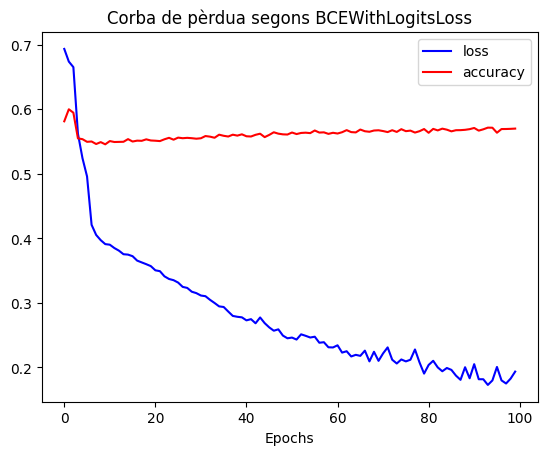

In [52]:
plt.plot(loss_model, '-b', label='loss')
plt.plot(acc_model, '-r', label='accuracy')

title = "Corba de pèrdua segons BCEWithLogitsLoss"
plt.xlabel("Epochs")
plt.legend()
plt.title(title)

# save image
plt.savefig(title+".png")  # should before show method

plt.show()


## Testing Epochs

In [13]:
dataset_test = PlayDataset(dataset_test)
dataloader_test = DataLoader(
    dataset_test,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Resultats de 5 Epochs:
              precision    recall  f1-score   support

           0     0.7387    0.5235    0.6128      1253
           1     0.7444    0.8823    0.8075      1971

    accuracy                         0.7429      3224
   macro avg     0.7416    0.7029    0.7102      3224
weighted avg     0.7422    0.7429    0.7318      3224

ROC AUC: 0.8273039681932313


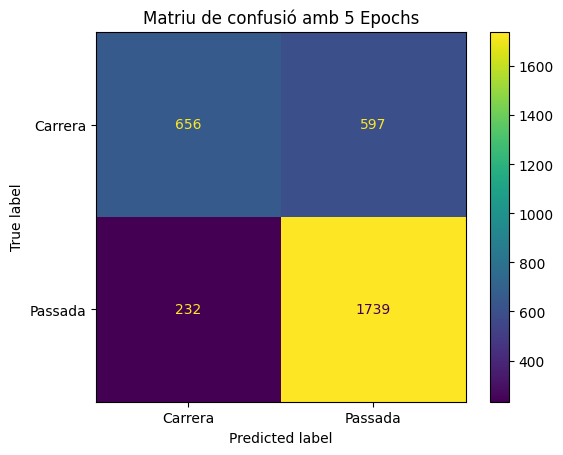


Resultats de 6 Epochs:
              precision    recall  f1-score   support

           0     0.6791    0.8747    0.7646      1253
           1     0.9025    0.7372    0.8115      1971

    accuracy                         0.7906      3224
   macro avg     0.7908    0.8059    0.7880      3224
weighted avg     0.8157    0.7906    0.7933      3224

ROC AUC: 0.8731608320649418


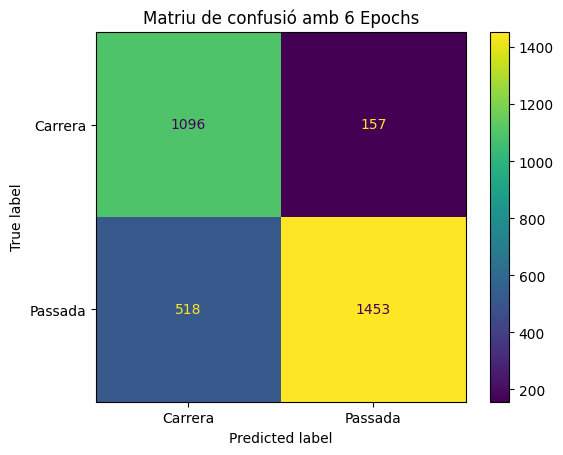


Resultats de 8 Epochs:
              precision    recall  f1-score   support

           0     0.7451    0.7933    0.7685      1253
           1     0.8630    0.8275    0.8449      1971

    accuracy                         0.8142      3224
   macro avg     0.8040    0.8104    0.8067      3224
weighted avg     0.8172    0.8142    0.8152      3224

ROC AUC: 0.8888075012663671


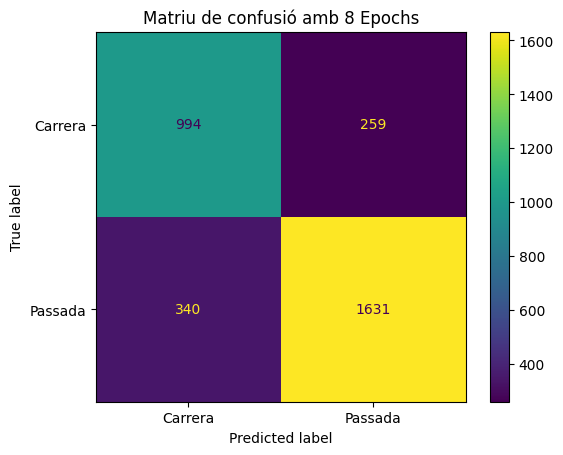


Resultats de 10 Epochs:
              precision    recall  f1-score   support

           0     0.7269    0.8348    0.7771      1253
           1     0.8840    0.8006    0.8403      1971

    accuracy                         0.8139      3224
   macro avg     0.8055    0.8177    0.8087      3224
weighted avg     0.8230    0.8139    0.8157      3224

ROC AUC: 0.8890277742347842


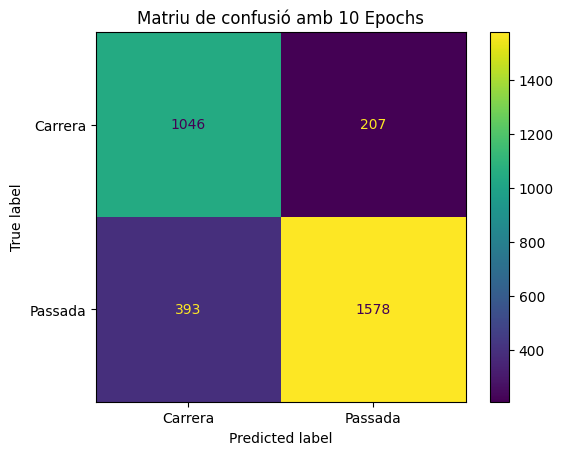


Resultats de 15 Epochs:
              precision    recall  f1-score   support

           0     0.7347    0.8244    0.7770      1253
           1     0.8790    0.8108    0.8435      1971

    accuracy                         0.8161      3224
   macro avg     0.8068    0.8176    0.8102      3224
weighted avg     0.8229    0.8161    0.8176      3224

ROC AUC: 0.8962056766449511


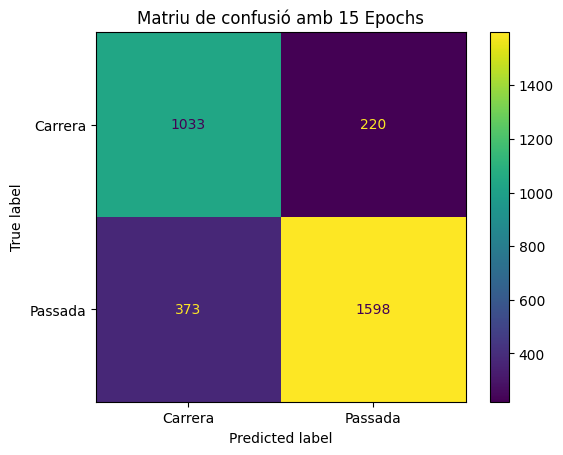


Resultats de 20 Epochs:
              precision    recall  f1-score   support

           0     0.7753    0.7462    0.7605      1253
           1     0.8424    0.8625    0.8523      1971

    accuracy                         0.8173      3224
   macro avg     0.8089    0.8044    0.8064      3224
weighted avg     0.8163    0.8173    0.8166      3224

ROC AUC: 0.8970323076468327


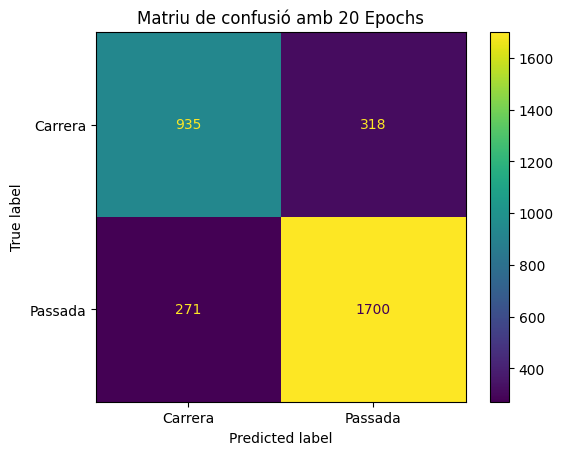


Resultats de 30 Epochs:
              precision    recall  f1-score   support

           0     0.8146    0.5539    0.6594      1253
           1     0.7643    0.9198    0.8349      1971

    accuracy                         0.7776      3224
   macro avg     0.7894    0.7369    0.7471      3224
weighted avg     0.7839    0.7776    0.7667      3224

ROC AUC: 0.8938110179405043


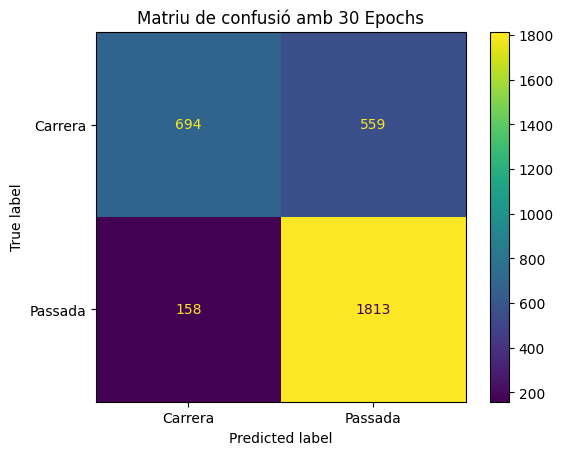


Resultats de 50 Epochs:
              precision    recall  f1-score   support

           0     0.7114    0.8420    0.7712      1253
           1     0.8863    0.7829    0.8314      1971

    accuracy                         0.8058      3224
   macro avg     0.7988    0.8124    0.8013      3224
weighted avg     0.8183    0.8058    0.8080      3224

ROC AUC: 0.8854495532386402


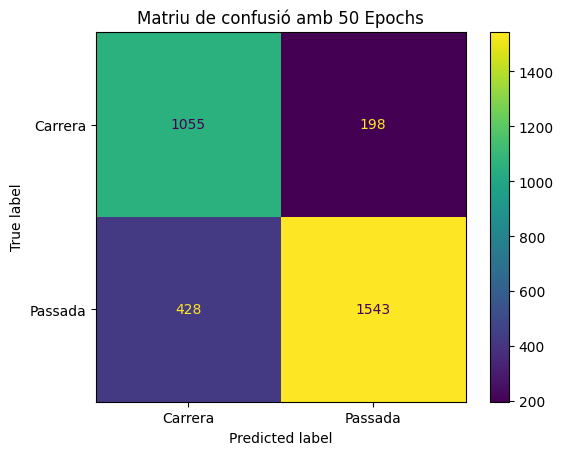


Resultats de 100 Epochs:
              precision    recall  f1-score   support

           0     0.7198    0.7749    0.7463      1253
           1     0.8496    0.8082    0.8284      1971

    accuracy                         0.7953      3224
   macro avg     0.7847    0.7916    0.7874      3224
weighted avg     0.7992    0.7953    0.7965      3224

ROC AUC: 0.8752530203513597


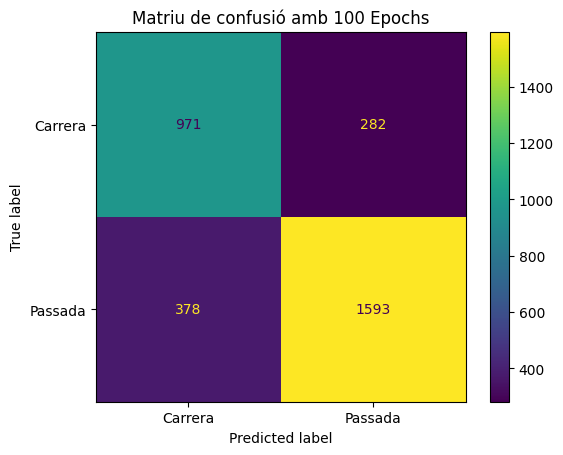

In [ ]:
reports = []

for epoch in epochs_save_list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    model = RunPassModel(
        player_feat_dim=12,
        track_feat_dim=7,
        hidden_dim=64,
        output_dim=1
    ).to(device)
    model.load_state_dict(torch.load(f"model_{epoch}Epochs.pth", weights_only=True))
    print(f"\nResultats de {epoch} Epochs:")
    all_labels, all_preds, report = test_model(model, dataloader_test)
    reports.append(report)
    print_confusion_matrix(all_labels, all_preds, title=f"Matriu de confusió amb {epoch} Epochs")


In [54]:
def get_percentage(num):
    return f"{round(num * 100, 2)}%"

rows = []
for i, report in enumerate(reports):
    row = [epochs_save_list[i],
           get_percentage(report["accuracy"]),
           get_percentage(report['0']['precision']),
           get_percentage(report['0']['recall']),
           get_percentage(report['0']['f1-score'])
           ]
    rows.append(row)

metrics = pd.DataFrame(data = rows, columns=["Epochs", "Accuracy", "Precision", "Recall", "f1-score"])
metrics

,Epochs,Accuracy,Precision,Recall,f1-score
0,5,74.29%,73.87%,52.35%,61.28%
1,6,79.06%,67.91%,87.47%,76.46%
2,8,81.42%,74.51%,79.33%,76.85%
3,10,81.39%,72.69%,83.48%,77.71%
4,15,81.61%,73.47%,82.44%,77.7%
5,20,81.73%,77.53%,74.62%,76.05%
6,30,77.76%,81.46%,55.39%,65.94%
7,50,80.58%,71.14%,84.2%,77.12%
8,100,79.53%,71.98%,77.49%,74.63%


In [55]:
print(metrics.to_latex(index=False, escape=True))

\begin{tabular}{rllll}
\toprule
Epochs & Accuracy & Precision & Recall & f1-score \\
\midrule
5 & 74.29\% & 73.87\% & 52.35\% & 61.28\% \\
6 & 79.06\% & 67.91\% & 87.47\% & 76.46\% \\
8 & 81.42\% & 74.51\% & 79.33\% & 76.85\% \\
10 & 81.39\% & 72.69\% & 83.48\% & 77.71\% \\
15 & 81.61\% & 73.47\% & 82.44\% & 77.7\% \\
20 & 81.73\% & 77.53\% & 74.62\% & 76.05\% \\
30 & 77.76\% & 81.46\% & 55.39\% & 65.94\% \\
50 & 80.58\% & 71.14\% & 84.2\% & 77.12\% \\
100 & 79.53\% & 71.98\% & 77.49\% & 74.63\% \\
\bottomrule
\end{tabular}

